In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
read_csv_kwarg = {'delimiter': ',',
    'skipinitialspace': True,
    'quotechar': '"',
    'encoding': 'utf-8',
    'header': 2}

df_balanced = pd.read_csv('../../Datasets/Audioset/balanced_train_segments.csv',**read_csv_kwarg)
df_unbalanced = pd.read_csv('../../Datasets/Audioset/unbalanced_train_segments.csv',**read_csv_kwarg)
df_eval = pd.read_csv('../../Datasets/Audioset/eval_segments.csv',**read_csv_kwarg)

df_train = pd.concat([df_balanced,df_unbalanced])
df_train = df_train.set_index('# YTID')
df_eval = df_eval.set_index('# YTID')
audio_to_zip = joblib.load('../../Datasets/Audioset/audio_to_zip.pkl')
available_ytids = list(audio_to_zip.keys())

class_map = pd.read_csv('../../Datasets/Audioset/audioset_class_map.csv')
class_map = class_map.reset_index().set_index('mid')

#dev_ytids = [y for y in available_ytids if y not in df_eval.index]
#df_train = df_train.loc[dev_ytids]

In [6]:
df_balanced = pd.read_csv('../../Datasets/Audioset/balanced_train_segments.csv',**read_csv_kwarg)
df_unbalanced = pd.read_csv('../../Datasets/Audioset/unbalanced_train_segments.csv',**read_csv_kwarg)
df_eval = pd.read_csv('../../Datasets/Audioset/eval_segments.csv',**read_csv_kwarg)
df_balanced = df_balanced.set_index('# YTID')
df_unbalanced = df_unbalanced.set_index('# YTID')
df_eval = df_eval.set_index('# YTID')

balanced_ytids = []
unbalanced_ytids = []
eval_ytids = []

for x in available_ytids:
    if x in df_balanced.index:
        balanced_ytids.append(x)
    elif x in df_eval.index:
        eval_ytids.append(x)
    else:
        unbalanced_ytids.append(x)

bal_len, unbal_len, eval_len = len(df_balanced), len(df_unbalanced), len(df_eval)
bal_ours, unbal_ours, eval_ours = len(df_balanced.loc[balanced_ytids]), len(df_unbalanced.loc[unbalanced_ytids]), len(df_eval.loc[eval_ytids])
print('Balanced set: {}/{} ({:.2f} %)'.format(bal_ours,bal_len,100*bal_ours/bal_len))
print('Unbalanced set: {}/{} ({:.2f} %)'.format(unbal_ours,unbal_len,100*unbal_ours/unbal_len))
print('Evaluation set: {}/{} ({:.2f} %)'.format(eval_ours,eval_len,100*eval_ours/eval_len))

Balanced set: 18026/22160 (81.34 %)
Unbalanced set: 1637982/2041789 (80.22 %)
Evaluation set: 16710/20371 (82.03 %)


In [81]:
class_counts = np.zeros((527,))
for logid, row in tqdm(df_train.iterrows()):
    for l in row['positive_labels'].split(','):
        class_counts[int(class_map.loc[l]['index'])] += 1     

class_counts = pd.DataFrame({'class_count': class_counts, 'class': class_map['display_name'].values})
class_counts = class_counts.sort_values(by='class_count',ascending=False)

1656008it [06:09, 4478.72it/s]


In [53]:
class_counts = class_counts.sort_index()

def calculate_sample_rarity(x):
    rarity = 0
    for l in x.split(','):
        rarity += 1.0/class_counts.iloc[int(class_map.loc[l]['index'])]['class_count']
    return rarity

df_train['rarity'] = df_train['positive_labels'].apply(calculate_sample_rarity)

In [57]:
sample_probs = (df_train['rarity']/527).values

In [58]:
df_train

,start_seconds,end_seconds,positive_labels,rarity
# YTID,,,,
-uLJl3o_AZw,30.0,40.0,"/m/04rlf,/m/0m0jc",0.000231
0Uf9LM840vA,40.0,50.0,/m/0k65p,0.003559
-BxQ9nkrId4,30.0,40.0,/m/07qv_x_,0.002294
0zfWGqDMT04,30.0,40.0,/m/08j51y,0.011765
1C6VhOCffIE,60.0,70.0,"/m/0342h,/m/03lty,/m/04szw,/m/07m2kt,/m/0dl5d",0.004751
...,...,...,...,...
NazYCG1ROwo,30.0,40.0,"/m/01z5f,/m/068hy,/m/0bt9lr,/m/0jbk",0.000888
N_G3NDX-K-0,30.0,40.0,/m/09x0r,0.000001
N_ses65_Nf0,30.0,40.0,/m/04rlf,0.000001


In [76]:
idxs = []
for i in range(160):
    idxs.append(np.random.choice(df_train.index[i*10000:(i+1)*10000], size=10000,replace=True,p=sample_probs[i*10000:(i+1)*10000]/np.sum(sample_probs[i*10000:(i+1)*10000])))

idxs = np.concatenate(idxs)

1600000it [07:55, 3368.17it/s]


Text(0.5, 1.0, 'Audioset class balance')

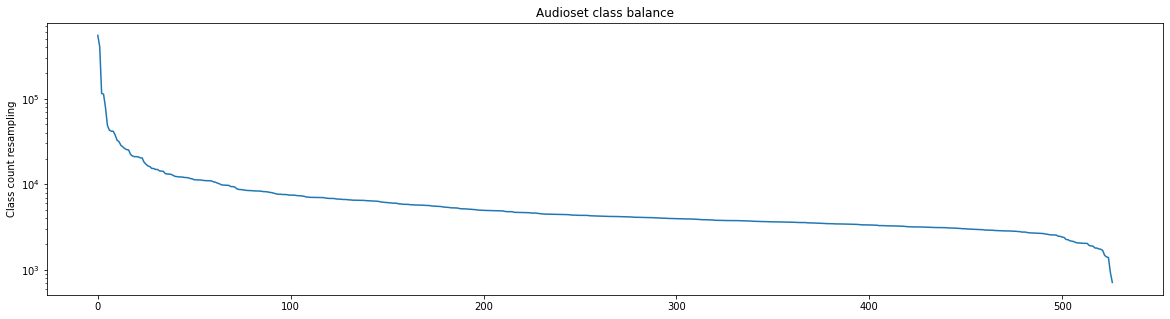

In [79]:
df_train_resampled_rarity = df_train.loc[idxs]

class_counts_resampled = np.zeros((527,))
for logid, row in tqdm(df_train_resampled_rarity.iterrows()):
    for l in row['positive_labels'].split(','):
        class_counts_resampled[int(class_map.loc[l]['index'])] += 1     

class_counts_resampled = pd.DataFrame({'class_count': class_counts_resampled, 'class': class_map['display_name'].values})
class_counts_resampled = class_counts_resampled.sort_values(by='class_count',ascending=False)

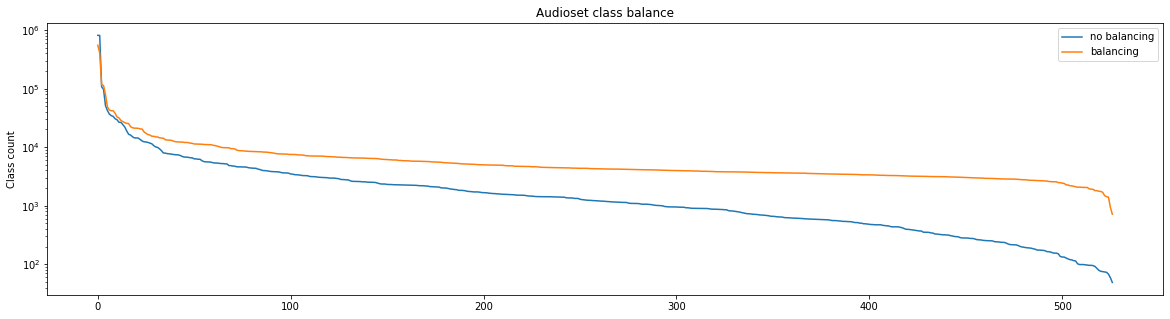

In [82]:
plt.figure(figsize=(20,5))
plt.plot(class_counts['class_count'].values, label='no balancing')
plt.plot(class_counts_resampled['class_count'].values,label='balancing')
plt.yscale('log')
plt.ylabel('Class count')
plt.title('Audioset class balance')
plt.legend()


In [86]:
joblib.dump(class_counts,'audioset_dev_class_counts.pickle')

['audioset_dev_class_counts.pickle']